##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Gemini 2.0 - Search as a tool

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/gemini-2/search_tool.ipynb"><img src="https://ai.google.dev/site-assets/images/docs/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In this notebook you will learn how to use the new Google Search tool available in [Gemini 2.0](https://ai.google.dev/gemini-api/docs/models/gemini-v2), using both the unary API and the Multimodal Live API. Check out the docs to learn more about using [Search as a tool](https://ai.google.dev/gemini-api/docs/models/gemini-v2#search-tool).

## Set up the SDK

This guide uses the [`google-genai`](https://pypi.org/project/google-genai) Python SDK to connect to the Gemini 2.0 models.

### Install SDK

The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides programmatic access to Gemini 2 (and previous models) using both the [Google AI for Developers](https://ai.google.dev/gemini-api/docs/models/gemini-v2) and [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview) APIs. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

More details about this new SDK on the [documentation](https://googleapis.github.io/python-genai/) or in the [Getting started](get_started.ipynb) notebook.

In [ ]:
!pip install -U -q google-genai

### Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/gemini-api-cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [ ]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

The client will pick up your API key from the environment variable.
To use the live API you need to set the client version to `v1alpha` and use the Gemini 2.0 model.

In [ ]:
from google import genai

client = genai.Client(http_options={'api_version': 'v1alpha'})

MODEL = 'gemini-2.0-flash-exp'

## Use search in chat

Start by defining a helper function that you will use to display each part of the returned response.

In [ ]:
# @title Define some helpers (run this cell)
import json

from IPython.display import display, HTML, Markdown


def show_json(obj):
  print(json.dumps(obj.model_dump(exclude_none=True), indent=2))

def show_parts(r):
  parts = r.candidates[0].content.parts
  if parts is None:
    finish_reason = r.candidates[0].finish_reason
    print(f'{finish_reason=}')
    return
  for part in r.candidates[0].content.parts:
    if part.text:
      display(Markdown(part.text))
    elif part.executable_code:
      display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    else:
      show_json(part)

  grounding_metadata = r.candidates[0].grounding_metadata
  if grounding_metadata and grounding_metadata.search_entry_point:
    display(HTML(grounding_metadata.search_entry_point.rendered_content))


First try a query that needs realtime information, so you can see how the model performs _without_ Google Search.

In [ ]:
chat = client.chats.create(model=MODEL)

r = chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')
show_parts(r)

To determine who won the most recent Australia vs. Chinese Taipei games, we need to specify which sport we're talking about. These two nations compete in a variety of sports. 

However, assuming you're most likely referring to **football (soccer)**, here's the answer:

**In football, the most recent match between Australia and Chinese Taipei was on November 21st, 2023, and Australia won 0 - 3.**

Therefore, **Australia** won the most recent football game between the two nations.

If you were interested in a different sport, please specify, and I'll do my best to provide you with the correct answer.


Now set up a new chat session that uses the `google_search` tool.  The `show_parts` helper will display the text output as well as any Google Search queries used in the results.

In [ ]:
search_tool = {'google_search': {}}
soccer_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

r = soccer_chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')
show_parts(r)

The most recent games between Australia and Chinese Taipei were both won by Australia.

*   **December 7, 2024:** Australia defeated Chinese Taipei 6-0 in a friendly match held in Geelong, Australia.
*   **December 4, 2024:** Australia defeated Chinese Taipei 3-1 in a friendly match held in Melbourne, Australia.

These were both friendly matches for the women's national teams.


As you are using a `chat` session, you can ask the model follow-up questions too.

In [ ]:
r = soccer_chat.send_message('Who scored the goals?')
show_parts(r)

Here's a breakdown of who scored in the two recent matches between Australia and Chinese Taipei:

**December 7, 2024 - Australia 6, Chinese Taipei 0**

*   **Leah Davidson:** Scored with a header, assisted by Emily van Egmond. This was her first international goal.
*   **Tameka Yallop:** Scored a solo goal after intercepting a pass.
*  **Emily Gielnik:** Scored with a header, assisted by Tameka Yallop. This was her first international goal since 2021.
*   **Michelle Heyman:** Scored with a close-range shot, assisted by Remy Siemsen.
*   **Tash Prior:** Scored with a header from a free kick by Emily van Egmond.
*   **Sharn Freier:** Scored with a shot from a long ball by Winonah Heatley.

**December 4, 2024 - Australia 3, Chinese Taipei 1**

*   **Natasha Prior:** Scored with a volley from a cross by Chloe Logarzo. This was her first international goal.
*   **Sharn Freier:** Scored with a header after a shot from Emily Gielnik hit the crossbar. This was her first international goal.
*   **Bryleeh Henry:** Scored with a header from a cross by Tameka Yallop. This was her first international goal.
*   **Chen Jin-Wen:** Scored for Chinese Taipei, assisted by Chan Pi-han.


## Plot search results


In this example you can see how to use the Google Search tool with code generation in order to plot results.

In [ ]:
movie_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

r = movie_chat.send_message('Generate some Python code to plot the runtimes of the last 10 Denis Villeneuve movies.')
show_parts(r)

Okay, here's the Python code to plot the runtimes of the last 10 Denis Villeneuve movies, along with explanations and the data used:

**1. Data Collection**

Based on the provided search results, here are the last 10 movies directed by Denis Villeneuve, along with their runtimes:

*   **Dune: Part Two** (2024) - 2 hours 46 minutes (166 minutes)
*   **Dune** (2021) - 2 hours 35 minutes (155 minutes)
*   **Blade Runner 2049** (2017) - 2 hours 44 minutes (164 minutes)
*   **Arrival** (2016) - 1 hour 56 minutes (116 minutes)
*   **Sicario** (2015) - 2 hours 1 minute (121 minutes)
*   **Enemy** (2013) - 1 hour 31 minutes (91 minutes)
*   **Prisoners** (2013) - 2 hours 33 minutes (153 minutes)
*    **Incendies** (2010) - 2 hours 11 minutes (131 minutes)
*    **Polytechnique** (2009) - 1 hour 17 minutes (77 minutes)
*    **Maelstrom** (2000) - 1 hour 27 minutes (87 minutes)

**2. Python Code**


```python
import matplotlib.pyplot as plt

movies = [
    "Dune: Part Two",
    "Dune",
    "Blade Runner 2049",
    "Arrival",
    "Sicario",
    "Enemy",
    "Prisoners",
    "Incendies",
    "Polytechnique",
    "Maelstrom"
]
runtimes_minutes = [166, 155, 164, 116, 121, 91, 153, 131, 77, 87]


plt.figure(figsize=(12, 6))
plt.bar(movies, runtimes_minutes, color='skyblue')
plt.xlabel("Movies")
plt.ylabel("Runtime (Minutes)")
plt.title("Runtimes of the Last 10 Denis Villeneuve Movies")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
```



**3. Code Explanation**
*   **Import matplotlib:** Imports the necessary library for plotting.
*   **Movie Data:** Lists the last 10 Denis Villeneuve movies and their respective runtimes in minutes.
*   **Create Plot:** Generates a bar chart with movie titles on the x-axis and runtimes on the y-axis.
*   **Labels and Title:** Adds appropriate labels and a title to the plot for clarity.
*   **X-Axis Rotation:** Rotates the movie titles on the x-axis for better readability.
*   **Display Plot:** Shows the generated plot.

**To Run the code**

1.  Make sure you have Python installed on your computer.
2.  Install the `matplotlib` library by running: `pip install matplotlib` in your terminal or command prompt.
3.  Save the code above as a `.py` file (e.g., `movie_runtimes.py`).
4.  Run the file from your terminal using: `python movie_runtimes.py`.

This will generate a bar chart showing the runtimes of the last 10 Denis Villeneuve movies.


First review the supplied code to make sure it does what you expect, then copy it here to try out the chart.

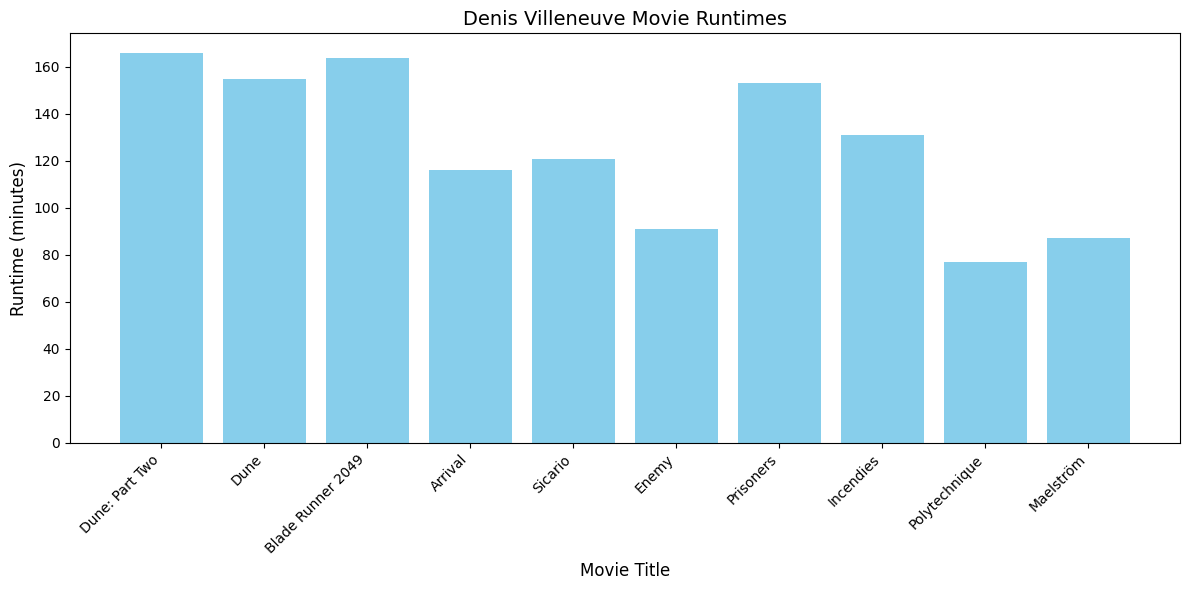

In [ ]:
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes).
# Data gathered from search results.
movies = {
    "Dune: Part Two": 166,
    "Dune": 155,
    "Blade Runner 2049": 164,
    "Arrival": 116,
    "Sicario": 121,
    "Enemy": 91,
    "Prisoners": 153,
    "Incendies": 131,
    "Polytechnique": 77,
    "Maelström": 87
}

movie_titles = list(movies.keys())
runtimes = list(movies.values())

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='skyblue')

# Add labels and title
plt.xlabel("Movie Title", fontsize=12)
plt.ylabel("Runtime (minutes)", fontsize=12)
plt.title("Denis Villeneuve Movie Runtimes", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10) # Rotate x-axis labels for better fit
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()

One feature of using a chat conversation to do this is that you can now ask the model to make changes.

In [ ]:
r = movie_chat.send_message('Looks great! Can you give the chart a dark theme instead?')
show_parts(r)

Certainly! Here's the updated Python code to generate the same chart but with a dark theme applied:



```python
import matplotlib.pyplot as plt

movies = [
    "Dune: Part Two",
    "Dune",
    "Blade Runner 2049",
    "Arrival",
    "Sicario",
    "Enemy",
    "Prisoners",
    "Incendies",
    "Polytechnique",
    "Maelstrom"
]
runtimes_minutes = [166, 155, 164, 116, 121, 91, 153, 131, 77, 87]

plt.figure(figsize=(12, 6), facecolor="#1e1e1e")  # Set figure facecolor
ax = plt.axes()
ax.set_facecolor("#2c2c2c")  # Set axes background color
plt.bar(movies, runtimes_minutes, color='#66b3ff')  # Use a lighter color for bars
plt.xlabel("Movies", color='white')
plt.ylabel("Runtime (Minutes)", color='white')
plt.title("Runtimes of the Last 10 Denis Villeneuve Movies", color='white')
plt.xticks(rotation=45, ha="right", color='white')
plt.yticks(color='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
plt.tight_layout()
plt.show()
```



**Changes Made for Dark Theme:**

*   **Figure and Axes Background:**
    *   `plt.figure(facecolor="#1e1e1e")`: Sets the background color of the entire figure to a very dark gray (`#1e1e1e`).
    *   `ax.set_facecolor("#2c2c2c")`: Sets the background color of the plotting area (axes) to a slightly lighter dark gray (`#2c2c2c`).
*   **Text Color:**
    *   `color='white'` is added to `plt.xlabel`, `plt.ylabel`, `plt.title`, `plt.xticks` and `plt.yticks` to make all the text white.
*   **Bar Color:**
    *   The bar color is changed to a light blue `color="#66b3ff"` to contrast well with the dark background.
*   **Spines Color**
    *   The spines are the lines that bound the plotting area. The color of the spines is set to white, so that they are visible on the dark background.

**How to Run:**

1.  Make sure you have Python and `matplotlib` installed.
2.  Save the updated code as a `.py` file (e.g., `dark_movie_runtimes.py`).
3.  Run the file from your terminal: `python dark_movie_runtimes.py`

This will now generate the same bar chart, but with a dark theme, making it more visually appealing in a dark environment.


Again, always be sure to review code generated by the model before running it.

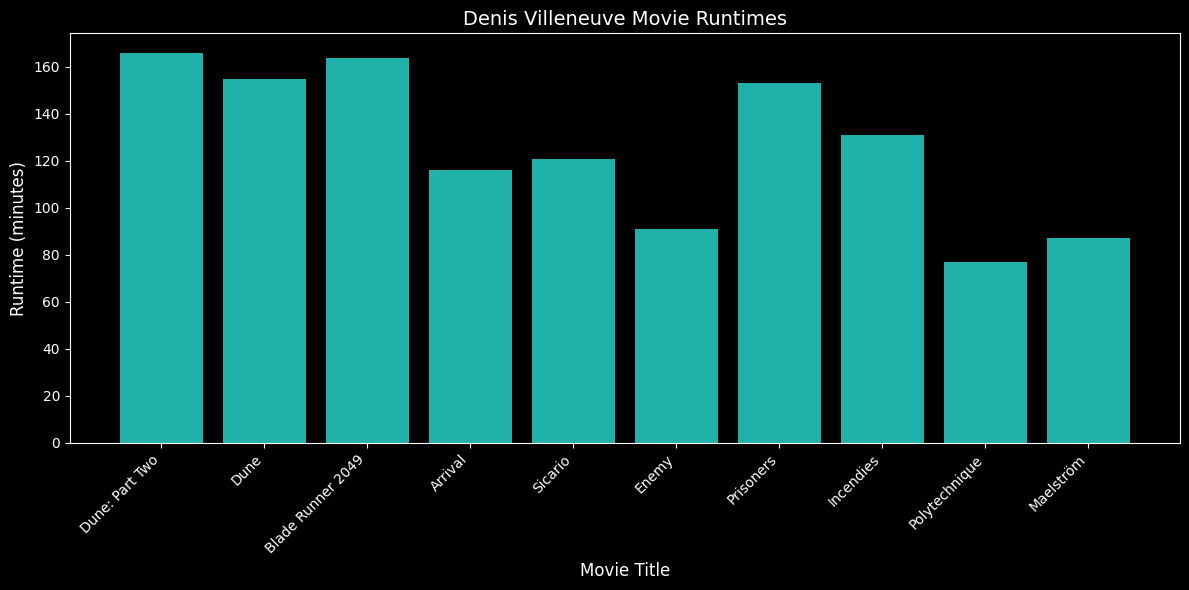

In [ ]:
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes).
# Data gathered from search results.
movies = {
    "Dune: Part Two": 166,
    "Dune": 155,
    "Blade Runner 2049": 164,
    "Arrival": 116,
    "Sicario": 121,
    "Enemy": 91,
    "Prisoners": 153,
    "Incendies": 131,
    "Polytechnique": 77,
    "Maelström": 87
}

movie_titles = list(movies.keys())
runtimes = list(movies.values())

# Set dark theme
plt.style.use('dark_background')

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='lightseagreen') #changed bar color

# Add labels and title
plt.xlabel("Movie Title", fontsize=12, color='white')
plt.ylabel("Runtime (minutes)", fontsize=12, color='white')
plt.title("Denis Villeneuve Movie Runtimes", fontsize=14, color='white')
plt.xticks(rotation=45, ha="right", fontsize=10, color='white') # Rotate x-axis labels for better fit
plt.yticks(color='white')
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()


## Use search in the Multimodal Live API

The Search tool can be used in a live streaming context to have the model formulate grounded responses during the conversation.

### Define some helpers

To use the bi-directional streaming API in Colab, you will buffer the audio stream. Define a `play_response` helper function to do the buffering, and once the audio for the current turn has completed, display an IPython audio widget.

As each of the following examples only use a single prompt, also define a `run` helper to wrap the setup and prompt execution steps into a single function call. This helper takes a `config` argument that will be added to the `generation_config`, so that you can toggle the Search tool between examples.

In [ ]:
import asyncio
import io
import json
import re
import time
import wave

import numpy as np
from IPython.display import Audio, display


DEFAULT_OUTPUT_RATE = 24000
BASE_MODEL_CONFIG = {
    'generation_config' : {
        # Here you can change the model's output mode between either audio or text.
        # While this code expects an audio stream, text should work, but the stream
        # may interleave with the `Buffering....` text.
        'response_modalities': ['AUDIO']
    },
}

async def play_response(stream):
  """Buffer audio output and display a widget. Returns the streamed responses."""
  turn_buf = io.BytesIO()
  sample_rate = DEFAULT_OUTPUT_RATE

  all_responses = []

  print('Buffering', end='')
  async for msg in stream.receive():
    all_responses.append(msg)

    if msg.server_content and msg.server_content.model_turn:
      # Handle content responses (e.g. audio, text)
      for part in msg.server_content.model_turn.parts:
        if inline_data := part.inline_data:
          # If there is inline_data, buffer it.
          audio_data = inline_data.data
          turn_buf.write(audio_data)

          # Capture the audio sample rate from the mime-type header too.
          if m := re.search('rate=(?P<rate>\d+)', part.inline_data.mime_type):
            sample_rate = int(m.group('rate'))

        elif text := part.text:
          print(text)

    elif tool_call := msg.tool_call:
      # Handle tool-call requests. Here is where you would implement
      # custom tool code, but for this example, all tools respond 'ok'.
      for fc in tool_call.function_calls:
        print('T', end='')
        tool_response = genai.types.LiveClientToolResponse(
            function_responses=[genai.types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': 'ok'},
            )]
        )
        await stream.send(tool_response)

    print('.', end='')

  print()

  # Play the audio
  if turn_buf.tell():
    audio = np.frombuffer(turn_buf.getvalue(), dtype=np.int16)
    display(Audio(audio, autoplay=True, rate=sample_rate))
  else:
    print('No audio :(')
    print(f'  {len(all_responses)=}')

  return all_responses


async def run(query, config=None):
  # Add any tools or other generation config.
  config = BASE_MODEL_CONFIG | (config or {})

  # Establish a live session. While this context manager is active, the
  # conversation will continue.
  async with client.aio.live.connect(model=MODEL, config=config) as strm:

    # Send the prompt.
    await strm.send(query, end_of_turn=True)
    # Handle the model response.
    responses = await play_response(strm)

    return responses

### Stream with the Search tool

First, execute a query _without_ the Search tool to observe the model's response to a time-sensitive query.

Note that the Multimodal Live API is a 2-way streaming API, but to simplify running in a notebook, each audio response is buffered and played once it has been fully streamed, so you will need to wait a few seconds before the response starts to play.

In [ ]:
await run('Who won the skateboarding gold medals in the 2024 olympics?');

Buffering...........................................................................................


Now re-run with the Search tool enabled.

In [ ]:
responses = await run('Who won the skateboarding gold medals in the 2024 olympics?', {'tools': [search_tool]})

Buffering..........................................................................................................


If you wish to see the full output that was returned, you can enable `show_output` here and run this cell. It includes the complete audio binary data, so it is off by default.

In [ ]:
show_output = False

if show_output:
  for msg in responses:
    print(msg.model_dump(exclude_none=True))

### Search with custom tools

In the Multimodal Live API, the Search tool can be used in conjunction with other tools, including function calls that you provide to the model.

In this example, you define a function `set_climate` that takes 2 parameters, `mode` (`hot`, `cold`, etc) and `strength` (0-10), and ask the model to set the climate control based on the live weather in the location you specify.

In [ ]:
set_climate_tool = {'function_declarations': [{
    'name': 'set_climate',
    'description': 'Switches the local climate control equipment to the specified parameters.',
    'parameters': {
      'type': 'OBJECT',
      'properties': {
        # Define the "mode" argument.
        'mode': {
            'type': 'STRING',
            'enum': [
              # Define the possible values for "mode".
              "hot",
              "cold",
              "fan",
              "off",
            ],
            'description': 'Mode for the climate unit - whether to heat, cool or just blow air.',
        },
        # Define the "strength" argument.
        'strength': {
            'type': 'INTEGER',
            'description': 'Intensity of the climate to apply, 0-10 (0 is off, 10 is MAX).',
        },
      },
    },
  },
]}

search_tool = {'google_search': {}}

tools = {'tools': [search_tool, set_climate_tool]}

responses = await run("Look up the weather in Paris and set my climate control appropriately.", tools)

Buffering..................T...........................................................................


Now inspect the `tool_call` response(s) you received during the conversation.

In [ ]:
for r in responses:
  if tool := r.tool_call:
    for fn in tool.function_calls:
      args = ', '.join(f'{k}={v}' for k, v in fn.args.items())
      print(f'{fn.name}({args})  # id={fn.id}')

set_climate(mode=fan, strength=5)  # id=function-call-3602646442978004963


## Next steps

<a name="next_steps"></a>

* For more demos showcasing multi-tool use in the Multimodal Live API, check out the [Plotting and Mapping cookbook](https://github.com/google-gemini/cookbook/blob/main/gemini-2/plotting_and_mapping.ipynb).
* To learn more about tool use in the Live API, check out the [Live API Tool Use cookbook](https://github.com/google-gemini/cookbook/blob/main/gemini-2/live_api_tool_use.ipynb).
* To get started with the Live API with the Python SDK, check out the [starter guide](https://github.com/google-gemini/cookbook/blob/main/gemini-2/live_api_starter.ipynb).

Also check the other Gemini 2.0 capabilities (like [spatial understanding](../gemini-2/spatial_understanding.ipynb)) that you can find in the [Gemini Cookbook](https://github.com/google-gemini/cookbook/blob/main/gemini-2/).